## 데이터 준비하기

In [1]:
# <압축풀기>

import os
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("../../../aiffel/python/dogs-vs-cats/{}.zip".format(zip_file), "r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [2]:
# <디렉토리 만들기>

import os
import shutil

# os.makedirs('./data/train/cats')
# os.makedirs('./data/train/dogs')
# os.makedirs('./data/test')

# for root, dirs, files in os.walk('./train/'):
#     for f in files:
#         if 'cat' in f:
#             file_to_move = os.path.join(root, f)
#             shutil.move(file_to_move, './data/train/cats')
#         elif 'dog' in f:
#             file_to_move = os.path.join(root, f)
#             shutil.move(file_to_move, './data/train/dogs')
# for root, dirs, files in os.walk('./test1/'):
#     for f in files:
#         file_to_move = os.path.join(root, f)
#         shutil.move(file_to_move, './data/test')

In [3]:
# <경로 지정하기>

# 기본 경로
base_dir = './data/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# 훈련에 사용되는 고양이/개 이미지 경로
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
cat_file_names = os.listdir(train_cats_dir)
dog_file_names = os.listdir(train_dogs_dir)
print(train_cats_dir)

print(train_dogs_dir)


# 테스트에 사용되는 이미지 경로
test_img_dir = test_dir
test_file_names = os.listdir(test_img_dir)
print(test_img_dir)


./data/train/cats
./data/train/dogs
./data/test


## 데이터셋 살펴보기

In [4]:
# <파일 이름>
print(cat_file_names[0:5])
print(dog_file_names[0:5])
print(test_file_names[0:5])


['cat.5077.jpg', 'cat.2718.jpg', 'cat.10151.jpg', 'cat.3406.jpg', 'cat.4369.jpg']
['dog.8011.jpg', 'dog.7322.jpg', 'dog.1753.jpg', 'dog.5535.jpg', 'dog.3144.jpg']
['9733.jpg', '63.jpg', '6400.jpg', '823.jpg', '4217.jpg']


In [5]:
# <파일 개수>
print('There are {} number of images in cats directory.'.format(len(cat_file_names)))
print('There are {} number of images in dogs directory.'.format(len(dog_file_names)))
print('There are {} number of images in test directory.'.format(len(test_file_names)))

There are 12500 number of images in cats directory.
There are 12500 number of images in dogs directory.
There are 12500 number of images in test directory.


## 이미지 데이터 전처리하기

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale = 1.0/255.,
                                   validation_split = 0.2)

train_gen = train_data_gen.flow_from_directory(train_dir,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                              subset='training')
validation_gen = train_data_gen.flow_from_directory(train_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  subset='validation')


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
print(train_gen[0][0].shape)
print(validation_gen[0][0].shape)

(32, 224, 224, 3)
(32, 224, 224, 3)


## 이미지 확인하기

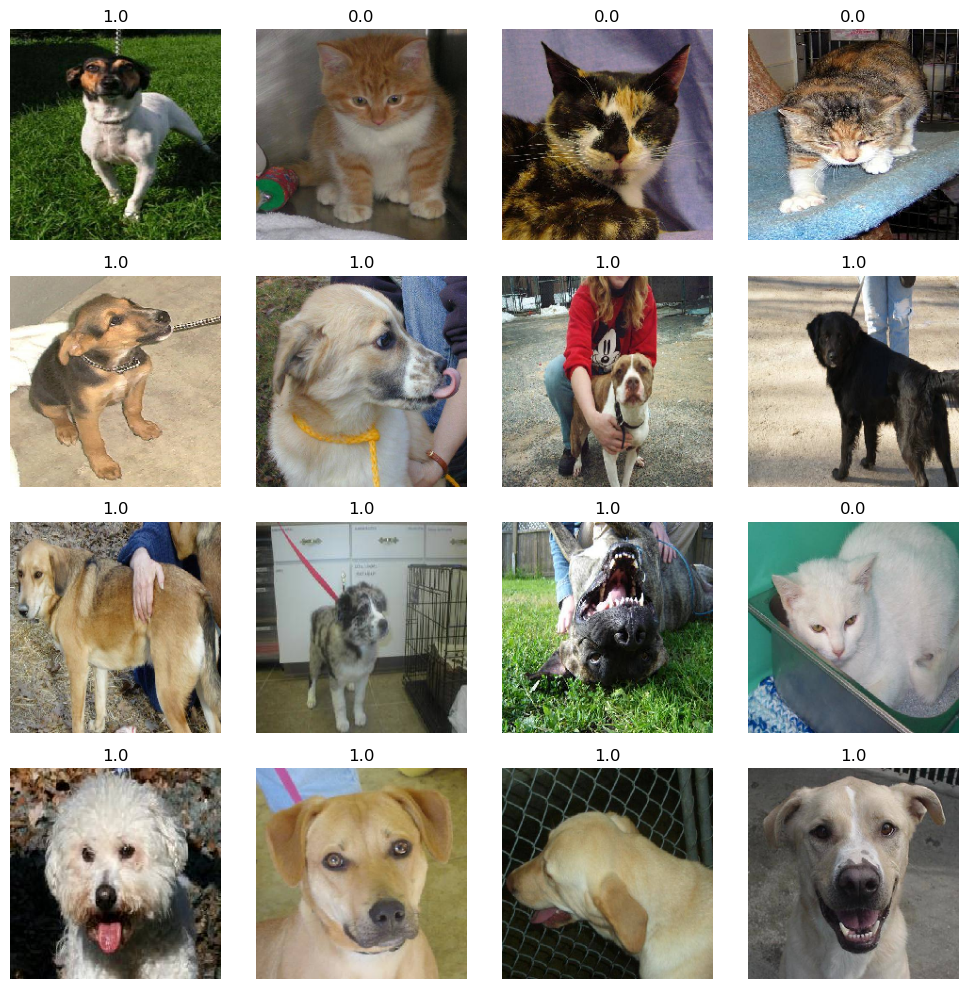

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img, label = train_gen.next()
    ax.imshow(img[0])
    ax.set_axis_off()
    ax.set_title(label[0])
    
plt.tight_layout()
plt.show()


## 모델 구성 및 평가(MobileNet)

**Step 1: Import the necessary libraries and modules:**

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


**Step 2: Load the MobileNet model with pre-trained weights (excluding the top fully connected layers):**

In [11]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

Metal device set to: Apple M1


**Step 3: Freeze the base model layers to prevent their weights from being updated during training:**

In [12]:
base_model.trainable = False

**Step 4: Add a custom top classifier on top of the base model:**

In [13]:
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

**Step 5: Set up Callbacks:**

In [14]:
checkpoint_filepath =('./model.h5') 

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                                               monitor = 'val_loss',
                                                               mode = 'min',
                                                               save_best_only = True)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 mode='max',
                                                 patience=2,
                                                 restore_best_weights= True)

**Step 6: Compile the model:**

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Step 7: Train the model using the train_gen generator for training and the validation_gen generator for validation:**

In [16]:
history= model.fit(train_gen,
                   steps_per_epoch = train_gen.samples // 32,
                   validation_data=validation_gen,
                   validation_steps = validation_gen.samples // 32,
                   epochs=10,
                   callbacks=[model_checkpoint_callback, early_stopping] )

Epoch 1/10


2023-07-08 15:36:18.309858: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


625/625 [==============================] - 88s 140ms/step - loss: 0.0931 - accuracy: 0.9651 - val_loss: 0.0464 - val_accuracy: 0.9836
Epoch 2/10
625/625 [==============================] - 103s 165ms/step - loss: 0.0408 - accuracy: 0.9858 - val_loss: 0.0377 - val_accuracy: 0.9868
Epoch 3/10
625/625 [==============================] - 141s 226ms/step - loss: 0.0347 - accuracy: 0.9875 - val_loss: 0.0359 - val_accuracy: 0.9874
Epoch 4/10
625/625 [==============================] - 152s 243ms/step - loss: 0.0316 - accuracy: 0.9885 - val_loss: 0.0338 - val_accuracy: 0.9874
Epoch 5/10
625/625 [==============================] - 170s 272ms/step - loss: 0.0284 - accuracy: 0.9898 - val_loss: 0.0334 - val_accuracy: 0.9884
Epoch 6/10
625/625 [==============================] - 177s 283ms/step - loss: 0.0271 - accuracy: 0.9903 - val_loss: 0.0358 - val_accuracy: 0.9874
Epoch 7/10
625/625 [==============================] - 187s 299ms/step - loss: 0.0252 - accuracy: 0.9908 - val_loss: 0.0326 - val_accurac

## 정확도와 손실 확인하기

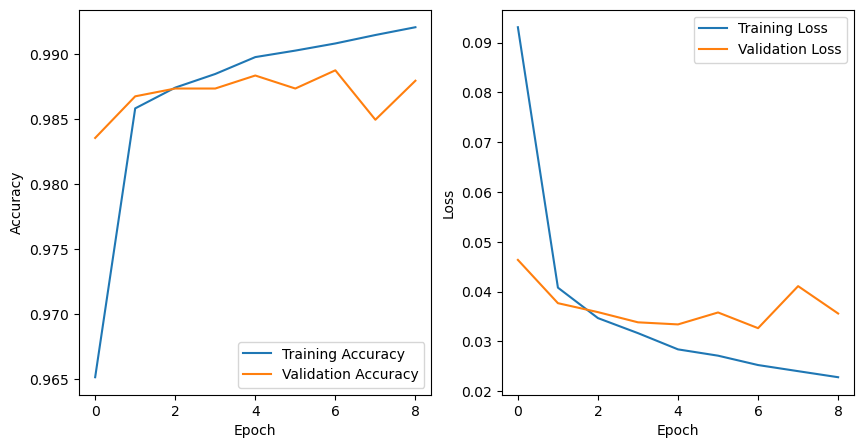

In [17]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Visualize training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set the path to the test directory
test_dir = './data/test/'
test_filenames = os.listdir(test_dir)

# Preprocess the test images and make predictions
predictions = []
for filename in test_filenames:
    img_path = os.path.join(test_dir, filename)
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, 0)  # Add batch dimension
    prediction = model.predict(img_array)[0][0]
    label = 1 if prediction > 0.5 else 0
    predictions.append(label)

# Remove file extensions from test filenames
test_filenames_no_ext = [os.path.splitext(filename)[0] for filename in test_filenames]

# Create a DataFrame with the modified filenames and predictions
submission_df = pd.DataFrame({'id': test_filenames_no_ext, 'label': predictions})

# Save the DataFrame as a CSV submission file
submission_df.to_csv('submission.csv', index=False)


1/1 [==============================] - 0s 19ms/step
